In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("S05-hw-dataset.csv")
df.head()


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [3]:
df.shape


(3000, 17)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [5]:
df["default"].value_counts(normalize=True)


default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

1) Загрузка данных и первичный EDA

Датасет загружен из файла `S05-hw-dataset.csv`.  
Размер данных: **3000 строк и 17 столбцов**.

По `df.info()` видно, что пропусков нет: для всех столбцов `Non-Null Count = 3000`.  
Все признаки числовые: 15 столбцов `int64` и 2 столбца `float64`.

Целевая переменная — `default` (1 — дефолт, 0 — нет дефолта).  
Распределение классов умеренно несбалансировано: `default=0` — **0.589667**, `default=1` — **0.410333**.

Далее для построения модели в признаках не будет использоваться `client_id`, так как это технический идентификатор и он может привести к некорректным выводам (утечка/необобщаемость).

In [6]:
y = df["default"]
X = df.drop(columns=["default", "client_id"])

X.shape, y.shape


((3000, 15), (3000,))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((2400, 15), (600, 15))

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)

acc_dummy, auc_dummy


(0.59, 0.5)

Baseline (DummyClassifier)

В качестве точки отсчёта используется `DummyClassifier(strategy="most_frequent")`, который всегда предсказывает самый частый класс на обучении.  
Такой бейзлайн не использует признаки и показывает “минимально ожидаемое” качество, с которым нужно сравнивать любую модель.

Далее сравниваю бейзлайн с логистической регрессией по метрикам `accuracy` и `ROC-AUC` (ROC-AUC считаю по вероятностям `predict_proba`).


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0]
}

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_


({'logreg__C': 100.0}, 0.8606625890118563)

In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score

best_model = gs.best_estimator_

y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

acc_lr, auc_lr


(0.8016666666666666, 0.87564879886087)

In [11]:
import pandas as pd

results = pd.DataFrame([
    {"model": "Dummy(most_frequent)", "accuracy": acc_dummy, "roc_auc": auc_dummy},
    {"model": "LogReg+Scaler (best C)", "accuracy": acc_lr, "roc_auc": auc_lr},
])
results


,model,accuracy,roc_auc
0,Dummy(most_frequent),0.590000,0.500000
1,LogReg+Scaler (best C),0.801667,0.875649


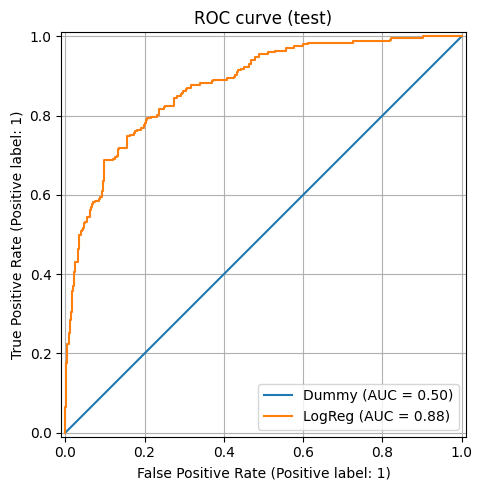

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_dummy, name="Dummy", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LogReg", ax=ax)
ax.grid(True)
ax.set_title("ROC curve (test)")

plt.tight_layout()
plt.savefig("figures/roc_curve.png", dpi=150)
plt.show()


Итоги эксперимента (выводы)

1) Датасет содержит 3000 объектов и 17 столбцов, пропусков нет; в модели использую 15 признаков (таргет `default`, `client_id` исключён как технический идентификатор).  
2) Баланс классов умеренно несбалансирован: `default=1` ≈ 0.4103, `default=0` ≈ 0.5897, поэтому кроме accuracy оцениваю также ROC-AUC.  
3) Бейзлайн `DummyClassifier(strategy="most_frequent")` дал `accuracy = 0.59` и `ROC-AUC = 0.50`, что соответствует практически случайному ранжированию по вероятностям.  
4) Логистическая регрессия в пайплайне со `StandardScaler` и подбором параметра регуляризации показала существенно лучшее качество.  
5) По результатам `GridSearchCV` лучшим оказался параметр `C = 100.0` (средний CV ROC-AUC ≈ 0.8667).  
6) На тестовой выборке лучшая модель дала `accuracy ≈ 0.8017` и `ROC-AUC ≈ 0.8756`, что значительно выше бейзлайна.  
7) По ROC-кривой видно, что модель хорошо отделяет класс дефолта от недефолта (кривая заметно выше диагонали).  
8) В рамках этого задания логистическая регрессия выглядит разумной базовой моделью для задачи скоринга: она проста, интерпретируема и даёт сильный прирост качества относительно простого бейзлайна.
